In [2]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


In [5]:
# Config & Setup Details
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Learning Config
cfg_split   = 0.8
cfg_seq_len = 600

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [6]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [7]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("\n********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

# Get Sales (Sum across all Stores) Grouped by Date
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()
print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("\n********\n")

# Resetting the index
df_train = df_grouped_date.reset_index()

# Show the New Table
print(f"Training Shape: {df_train.shape}")
print(df_train)
print(f"Training Cols: {df_train.columns}")
print("\n********\n")



Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]

********

Training Shape: (1826, 3)
      index       date  sales
0         0 2013-01-01  13696
1         1 2013-01-02  13678
2         2 2013-01-03  14488
3         3 2013-01-04  15677
4         4 2013-01-05  16237
...     ...        ...    ...
1821   1821 2017-12-27  20378
1822   1822 2017-12-28  21885
1823   1823 2017-12-29  23535
1824   1824 2017-12-30  24988
1825   1825 2017-12-31  26420

[1826 rows x 3 columns]
Training Col

In [8]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data = df_train['sales'].values.reshape(-1, 1)
scaled_sales_data = scaler.fit_transform(sales_data)
df_train['sales'] = scaled_sales_data


df_avg = df_train

# Set the Roling Average of the last 7 days
df_avg['sales'] = df_avg['sales'].rolling(window=7, min_periods=1).mean()

# Displaying the updated DataFrame with moving averages
df_avg.head(10) 

,index,date,sales
0,0,2013-01-01,0.059801
1,1,2013-01-02,0.059530
2,2,2013-01-03,0.067566
3,3,2013-01-04,0.080529
4,4,2013-01-05,0.091678
5,5,2013-01-06,0.104398
6,6,2013-01-07,0.089742
7,7,2013-01-08,0.089157
8,8,2013-01-09,0.090017
9,9,2013-01-10,0.090679


In [9]:
# Setup the Dataframe being used
df = df_avg # Simple Copy
df.set_index('date', inplace=True)
print(f"DF Shape: {df.shape}")

df.head(10) 

DF Shape: (1826, 2)


,index,sales
date,,
2013-01-01,0,0.059801
2013-01-02,1,0.059530
2013-01-03,2,0.067566
2013-01-04,3,0.080529
2013-01-05,4,0.091678
2013-01-06,5,0.104398
2013-01-07,6,0.089742
2013-01-08,7,0.089157
2013-01-09,8,0.090017


In [ ]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

In [10]:
class SinePositionEmbedding(torch.nn.Module):
    def __init__(self,
                 max_wavelength=10000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = torch.Tensor([max_wavelength])

    def forward(self, x):
        input_shape = x.shape
        input_type = x.dtype
        seq_length = x.shape[-2]
        hidden_size = x.shape[-1]
        position = torch.arange(seq_length).to(input_type)
        min_freq = (1 / self.max_wavelength).to(input_type)
        timescales = torch.pow(
            min_freq,
            (2 * (torch.arange(hidden_size) // 2)).to(input_type)
            / torch.Tensor([hidden_size]).to(input_type)
        )
        angles = torch.unsqueeze(position, 1) * torch.unsqueeze(timescales, 0)
        cos_mask = (torch.arange(hidden_size) % 2).to(input_type)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )
        return torch.broadcast_to(positional_encodings, input_shape).to(device)

In [12]:
temp = SinePositionEmbedding()
temp(torch.ones(size=(1,1826,50)))[0,:,:]

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.3795e-01,  ...,  1.0000e+00,
          1.4454e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.8254e-01,  ...,  1.0000e+00,
          2.8909e-04,  1.0000e+00],
        ...,
        [ 7.6835e-01,  6.4003e-01, -9.9000e-01,  ...,  9.2834e-01,
          2.6046e-01,  9.6548e-01],
        [ 9.5371e-01, -3.0074e-01, -8.5235e-01,  ...,  9.2826e-01,
          2.6060e-01,  9.6545e-01],
        [ 2.6223e-01, -9.6501e-01, -3.2281e-01,  ...,  9.2818e-01,
          2.6074e-01,  9.6541e-01]])

In [13]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)]['sales'].values
        y = data.iloc[i + seq_length]['sales']
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

In [14]:
x, y = create_sequences(df, cfg_seq_len)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
train_size = int(cfg_split * len(x_tensor))

x_train = x_tensor[:train_size]
#x_train = x_train.unsqueeze(-1)

y_train = y_tensor[:train_size]

x_val = x_tensor[train_size:]
y_val = y_tensor[train_size:]

In [15]:
print(f"x Shape: {x.shape}")
print(f"y Shape: {y.shape}")
print("")
print(f"x_train Shape: {x_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print("")
print(f"x_val Shape: {x_val.shape}")
print(f"y_val Shape: {y_val.shape}")

x Shape: (1226, 600)
y Shape: (1226,)

x_train Shape: torch.Size([980, 600])
y_train Shape: torch.Size([980])

x_val Shape: torch.Size([246, 600])
y_val Shape: torch.Size([246])


In [16]:
class LSTMModel(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 num_layers,
                 scaler = 10000,
                 **kwargs):
        super().__init__(**kwargs)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = nn.Linear(hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.scaler = scaler

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    # No complications with regression...
    def predict(self, x):
        return self(x)
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        y = x
        y, _ = self.lstm(y)
        y = y[:, -1, :] # Extract only the last time step
        y = self.linear(y) # Using linear to bring back to output_size
        y = y.squeeze()
        return y

    def training_step(self, train_batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        return loss


# Model parameters
input_size  = 1  # Number of features (sales data from 10 stores)
hidden_size = 50 # Number of features in hidden state
output_size = 1  # Number of output values (future sales prediction)
num_layers  = 4  # Number of stacked LSTM layers

# Create the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [17]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [5]                       --
├─LSTM: 1-1                              [5, 600, 50]              71,800
├─Linear: 1-2                            [5, 1]                    51
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 215.40
Input size (MB): 2.94
Forward/backward pass size (MB): 1.20
Params size (MB): 0.29
Estimated Total Size (MB): 4.43

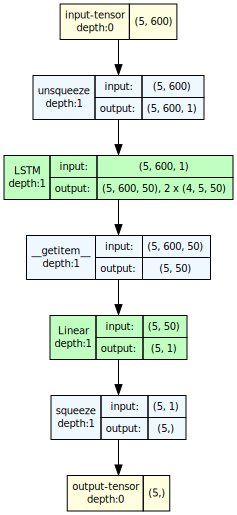

In [18]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(x_train[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [19]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_val).float(), 
                                              torch.Tensor(y_val).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [20]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [21]:
trainer = pl.Trainer(logger=logger, max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lightning_logs/Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.34971895813941956    │
│        val_offset         │    28.584373474121094     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.34971895813941956, 'val_offset': 28.584373474121094}]

In [23]:
trainer.fit(model, xy_train, xy_val) 


  | Name    | Type      | Params
--------------------------------------
0 | lstm    | LSTM      | 71.8 K
1 | dropout | Dropout1d | 0     
2 | linear  | Linear    | 51    
3 | loss    | MSELoss   | 0     
--------------------------------------
71.9 K    Trainable params
0         Non-trainable params
71.9 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [24]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_loss,val_offset,epoch,step,train_loss,train_offset
0,0.349719,28.584373,0,0,NaN,NaN
1,0.039082,7.611374,0,19,NaN,NaN
2,NaN,NaN,0,19,0.074523,6.309222
3,0.030986,6.183806,1,39,NaN,NaN
4,NaN,NaN,1,39,0.022671,1.181558
5,0.038971,7.651179,2,59,NaN,NaN
6,NaN,NaN,2,59,0.022057,-0.097155
7,0.035917,7.358379,3,79,NaN,NaN
8,NaN,NaN,3,79,0.020392,-0.368066
9,0.009634,2.863413,4,99,NaN,NaN


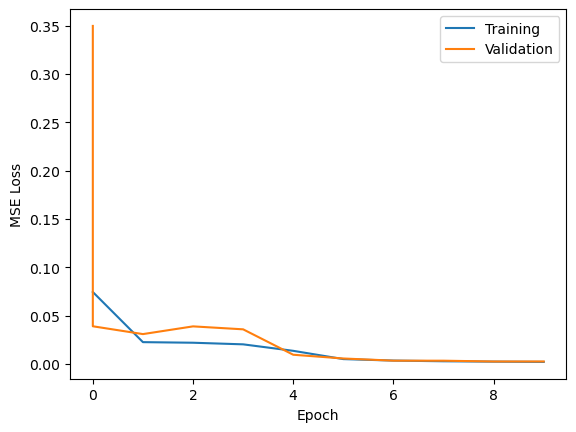

In [25]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("MSE Loss") 
plt.xlabel("Epoch") 
plt.show()

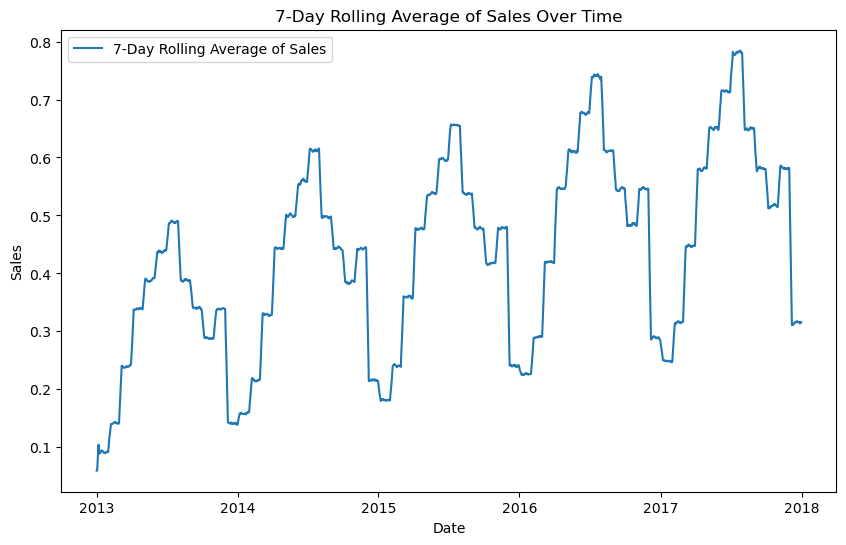

In [26]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(df['sales'], label='7-Day Rolling Average of Sales')  # Plot the sales data
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Sales')  # Label for the y-axis
plt.title('7-Day Rolling Average of Sales Over Time')  # Title of the plot
plt.legend()  # Add a legend
plt.show() 

In [47]:

last_50_sales = df_avg['sales'][-300:]
sales_array = last_50_sales.values
sales_array_reshaped = sales_array.reshape(1, -1)
print(sales_array_reshaped.shape)


tensor_input = torch.tensor(sales_array_reshaped, dtype=torch.float32)

print(tensor_input.shape)
print(tensor_input)

for i in range(90):
    pred = model.predict(tensor_input)
    print(pred)
    sales_array_reshaped.append([pred])
    #tensor_input = torch.cat(tensor_input, torch.tensor(pred, dtype=torch.float32))

print(tensor_input.shape)
print(tensor_input)


(1, 300)
torch.Size([1, 300])
tensor([[0.4456, 0.4470, 0.4456, 0.4456, 0.4470, 0.4475, 0.4482, 0.4500, 0.4476,
         0.4487, 0.4482, 0.4484, 0.4470, 0.4458, 0.4452, 0.4469, 0.4463, 0.4463,
         0.4467, 0.4478, 0.4483, 0.4483, 0.4471, 0.4483, 0.4479, 0.4684, 0.4900,
         0.5059, 0.5221, 0.5387, 0.5570, 0.5786, 0.5804, 0.5796, 0.5793, 0.5798,
         0.5811, 0.5803, 0.5786, 0.5770, 0.5765, 0.5767, 0.5765, 0.5770, 0.5786,
         0.5800, 0.5802, 0.5828, 0.5819, 0.5825, 0.5820, 0.5813, 0.5826, 0.5819,
         0.5806, 0.5883, 0.5986, 0.6078, 0.6176, 0.6277, 0.6398, 0.6514, 0.6517,
         0.6511, 0.6516, 0.6527, 0.6511, 0.6505, 0.6503, 0.6495, 0.6496, 0.6480,
         0.6468, 0.6486, 0.6500, 0.6520, 0.6527, 0.6513, 0.6523, 0.6530, 0.6530,
         0.6515, 0.6496, 0.6489, 0.6476, 0.6481, 0.6558, 0.6635, 0.6747, 0.6861,
         0.6929, 0.7043, 0.7137, 0.7158, 0.7160, 0.7156, 0.7155, 0.7156, 0.7152,
         0.7151, 0.7136, 0.7134, 0.7144, 0.7143, 0.7158, 0.7157, 0.7152, 0.7144

AttributeError: 'numpy.ndarray' object has no attribute 'append'

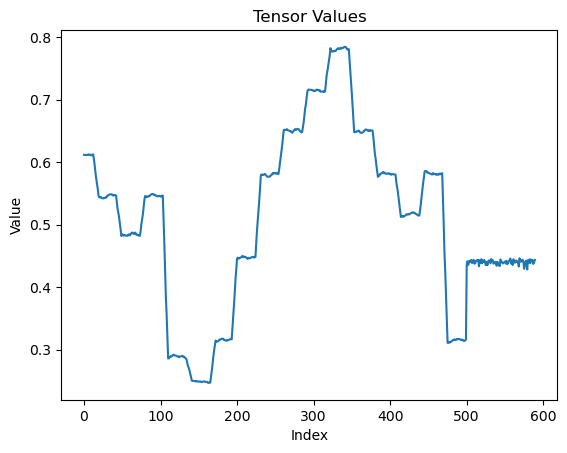

In [23]:
# if tensor_input.is_cuda:
#     tensor_input = tensor_input.cpu()

# Convert to NumPy array
numpy_array = tensor_input.squeeze().detach().numpy()

plt.plot(numpy_array)
plt.xlabel('Index')  # Adjust as per your data's context
plt.ylabel('Value')  # Adjust this label to reflect what the values represent
plt.title('Tensor Values')  # Provide a suitable title
plt.show()
